In [1]:
import sys
sys.path.insert(0, '..\\..\\frxas.py')

import numpy as np
import h5py
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, minimize, report_fit

from frxas import hdf5_io
from frxas import models
from frxas import visualization

%reload_ext autoreload
%autoreload 2

In [2]:
def chi_pattern(x, aoo, gamma, ld, tg, yd, f, L, po2, po2_ref):
    r"""Summarize the function in one line.

    Function for dimensionless vacancy concentrations assuming ideal behavior
    and overpotential control.

    Parameters
    ----------
    x : list or np.ndarray
        Array or list of arrays of length values.
    ld : float
        :math:`l_{\delta}` : Characteristic length scale of vacancy profile,
        often called the "utilization length".
    tg : float
        :math:`t_G`  : Characteristic time scale of vacancy profile. Reflects
        time scale of switching from kinetic limitations (low frequency) to
        co-limitation by kinetics and diffusion (moderate to high frequency).
    aoo : float
        :math:`A_o` : Thermodynamic factor.
    kappa : float
        Bleh bleah
    f : float
        Applied linear frequency in units of Hz.

    Returns
    -------
    np.ndarray
        Evaluated function for given length array and parameters.
    """
    g =gamma
    w = 2 * np.pi * f
    ao = models.calc_ao(aoo, po2, po2_ref)

    chi = -1 /(ao * L * (1 / L +  g / ld * np.sqrt(1 + 1j * tg * w))) \
    * np.exp(-(x + yd) / ld * np.sqrt(1 + 1j * tg * w))

    return chi

In [3]:
f1 = hdf5_io.get_all_datasets('July18_frXAS', start_indices = [[4, 0, 2, 2], [4, 0, 6, 0], [1, 0, 2]])
hdf5_io.close_frxas_file('July18_frXAS')

In [4]:
x, data, frequencies, gases, sizes = hdf5_io.unpack_data(f1, kind='data_adj')

In [5]:
colors = ['k', 'r', 'b', 'c']
markers = [(6, 2, 0), 's', '^', 'o']

colors = colors * (len(colors) % len(data))
markers = markers * (len(colors) % len(data))

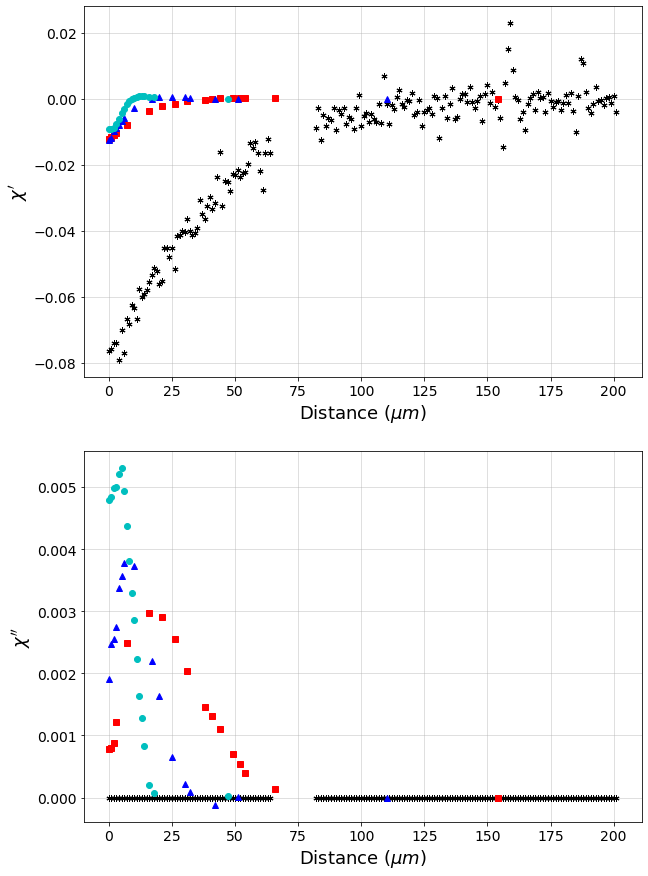

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(10,15))

for iy in np.arange(0,sizes[0]):
    visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy], marker=markers[iy], ls='')
# for iy in np.arange(sizes[0],sum(sizes[:2])):
#     visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy], marker=markers[iy], ls='')
# for iy in np.arange(sum(sizes[:2]),sum(sizes)):
#     visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy], marker=markers[iy], ls='')

plt.show()

In [7]:
fit_params = Parameters()

for iy, y in enumerate(data):
    fit_params.add('aoo_%i' % (iy+1), value=1.5, min=1, max=5)
    fit_params.add('gamma_%i' % (iy+1), value=1, min=0, max=1000)
    fit_params.add('ld_%i' % (iy+1), value=15, min=0.0, max=200)
    fit_params.add('tg_%i' % (iy+1), value=.1, min=0.01, max=10.0)
    fit_params.add('yd_%i' % (iy+1), value=1, min=0, max=5)
    fit_params.add('f_%i' % (iy+1), value=frequencies[iy], vary=False)
    fit_params.add('L_%i' % (iy+1), value=.65, vary=False)
    fit_params.add('po2_%i' % (iy+1), value=gases[iy], vary=False)
    fit_params.add('po2_ref_%i' % (iy+1), value=1, vary=False)

# Setting all aoo to be equal
for iy in np.arange(1, len(data)):
    fit_params['aoo_%i' % (iy+1)].expr = 'aoo_1'

# Setting other parameters within each dataset to be equal
for iy in np.arange(1, sizes[0]):
    fit_params['gamma_%i' % (iy+1)].expr = 'gamma_1'
    fit_params['ld_%i' % (iy+1)].expr = 'ld_1'
    fit_params['tg_%i' % (iy+1)].expr = 'tg_1'

for iy in np.arange(sizes[0]+1, sum(sizes[:2])):
    fit_params['gamma_%i' % (iy+1)].expr = 'gamma_5'
    fit_params['ld_%i' % (iy+1)].expr = 'ld_5'
    fit_params['tg_%i' % (iy+1)].expr = 'tg_5'

for iy in np.arange(sum(sizes[:2])+1, len(data)):
    fit_params['gamma_%i' % (iy+1)].expr = 'gamma_9'
    fit_params['ld_%i' % (iy+1)].expr = 'ld_9'
    fit_params['tg_%i' % (iy+1)].expr = 'tg_9'

In [8]:
mini=lmfit.Minimizer(models.objective_fun, fit_params, fcn_args=(x, data, chi_pattern))

In [9]:
out = mini.minimize(method='leastsq')
print(out.redchi)
report_fit(out.params)

8.007625415094289e-06
[[Variables]]
    aoo_1:       1.00000000 (init = 1.5)
    gamma_1:     666.435473 (init = 1)
    ld_1:        39.0249210 (init = 15)
    tg_1:        10.0000000 (init = 0.1)
    yd_1:        9.0483e-14 (init = 1)
    f_1:         0 (fixed)
    L_1:         0.65 (fixed)
    po2_1:       0.01 (fixed)
    po2_ref_1:   1 (fixed)
    aoo_2:       1.00000000 == 'aoo_1'
    gamma_2:     666.435473 == 'gamma_1'
    ld_2:        39.0249210 == 'ld_1'
    tg_2:        10.0000000 == 'tg_1'
    yd_2:        4.07110807 (init = 1)
    f_2:         0.25 (fixed)
    L_2:         0.65 (fixed)
    po2_2:       0.01 (fixed)
    po2_ref_2:   1 (fixed)
    aoo_3:       1.00000000 == 'aoo_1'
    gamma_3:     666.435473 == 'gamma_1'
    ld_3:        39.0249210 == 'ld_1'
    tg_3:        10.0000000 == 'tg_1'
    yd_3:        2.7756e-16 (init = 1)
    f_3:         1 (fixed)
    L_3:         0.65 (fixed)
    po2_3:       0.01 (fixed)
    po2_ref_3:   1 (fixed)
    aoo_4:       1.00000000 =

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(0,sizes[0]):
    visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy],
                           marker=markers[iy], ls='',
                           label=str(frequencies[iy]) + ' Hz')
for iy in np.arange(0,sizes[0]):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], chi_pattern),
                           color=colors[iy], marker='',
                           label=str(frequencies[iy]) + ' Hz')
    
axes[0].set_title('1% $O_2$', fontsize=18)
plt.legend()
plt.show()
# plt.savefig(r'Plots\Pattern_Model_Amp_yd_1%O2.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(sizes[0],sum(sizes[:2])):
    visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy],
                           marker=markers[iy], ls='',
                           label=str(frequencies[iy]) + ' Hz')

for iy in np.arange(sizes[0],sum(sizes[:2])):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], chi_pattern),
                           color=colors[iy], marker='',
                           label=str(frequencies[iy]) + ' Hz Fit')
    
axes[0].set_title('10% $O_2$', fontsize=18)
plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(sum(sizes[:2]),sum(sizes)):
    visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy],
                           marker=markers[iy], ls='', 
                           label=str(frequencies[iy]) + ' Hz')
for iy in np.arange(sum(sizes[:2]),sum(sizes)):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], chi_pattern),
                           color=colors[iy], marker='',
                           label=str(frequencies[iy]) + ' Hz Fit')
    
axes[0].set_title('100% $O_2$', fontsize=18)
plt.legend()
plt.show()

Data clearly not fitting to the patterned model. Seemingly occurs because the real data isn't scaled to 1 (max values for real components are ~0.002)